In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import yasa
from mne.filter import resample
import pynapple as nap
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize
import requests
from io import BytesIO
import sails
import re
from scipy.stats import entropy

import scipy
from scipy import signal
from scipy.interpolate import griddata
from scipy.signal import correlate
from scipy.stats import pearsonr
from scipy.fft import fft
from scipy.spatial.distance import euclidean
from scipy.signal import spectrogram
from scipy.io import loadmat
import scipy.fft
import scipy.stats
import scipy.io as sio
from scipy.signal import hilbert

import emd as emd
import emd.sift as sift
import emd.spectra as spectra

from neurodsp.sim import sim_combined
from neurodsp.plts import plot_time_series, plot_timefrequency
from neurodsp.utils import create_times
from neurodsp.timefrequency.wavelets import compute_wavelet_transform
from neurodsp.filt import filter_signal

# Load required libraries
from scipy.io import loadmat
from scipy.signal import hilbert
from scipy.interpolate import interp1d
from neurodsp.filt import filter_signal, filter_signal_fir, design_fir_filter
from sklearn.preprocessing import Normalizer
from tqdm import tqdm
import plotly.express as px
import copy
import umap.umap_ as umap
import skdim
from scipy.spatial import cKDTree
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.cm import ScalarMappable

## UTILS
from utils import *
from detect_pt import *

from scipy.io import loadmat
from neurodsp.filt import filter_signal
from scipy.spatial import cKDTree

sns.set(style='white', context='notebook')

from spectral_connectivity import Multitaper
from spectral_connectivity import Connectivity
from spectral_connectivity import multitaper_connectivity

General information:
folder 1, OD, post-trial 2

In [2]:
path_to_hpc = r"D:\OS_Basic\Rat_3\Rat_OS_Ephys_Rat3_SD3_HC_15_11_2017\post_trial4_2017-11-15_13-14-18\HPC_100_CH15.continuous.mat"
path_to_pfc = r"D:\OS_Basic\Rat_3\Rat_OS_Ephys_Rat3_SD3_HC_15_11_2017\post_trial4_2017-11-15_13-14-18\PFC_100_CH49.continuous.mat"
path_to_states = r"D:\OS_Basic\Rat_3\Rat_OS_Ephys_Rat3_SD3_HC_15_11_2017\post_trial4_2017-11-15_13-14-18\post_trial4_2017-11-15_13-14-18-states.mat"

config = emd.sift.SiftConfig.from_yaml_file(r"C:\Users\ejsev\Downloads\sleep scoring\emd_masksift_CA1_config_2500.yml")

In [3]:
def get_data2(lfp_path, state_path):

    data = scipy.io.loadmat(lfp_path)
    states = scipy.io.loadmat(state_path)

    lfp = np.squeeze(data['PFC'])
    hypno = np.squeeze(states['states'])

    fs = extract_frequency_sampling(lfp, hypno)

    unique = np.unique(hypno)
    if unique[0] == 0:
        print('There was 0 in the dataset')
        lfp = lfp[7*fs:-11*fs]
        hypno = hypno[7:-11]
    else:
        None

    return lfp, hypno, fs

There was 0 in the dataset
There was 0 in the dataset


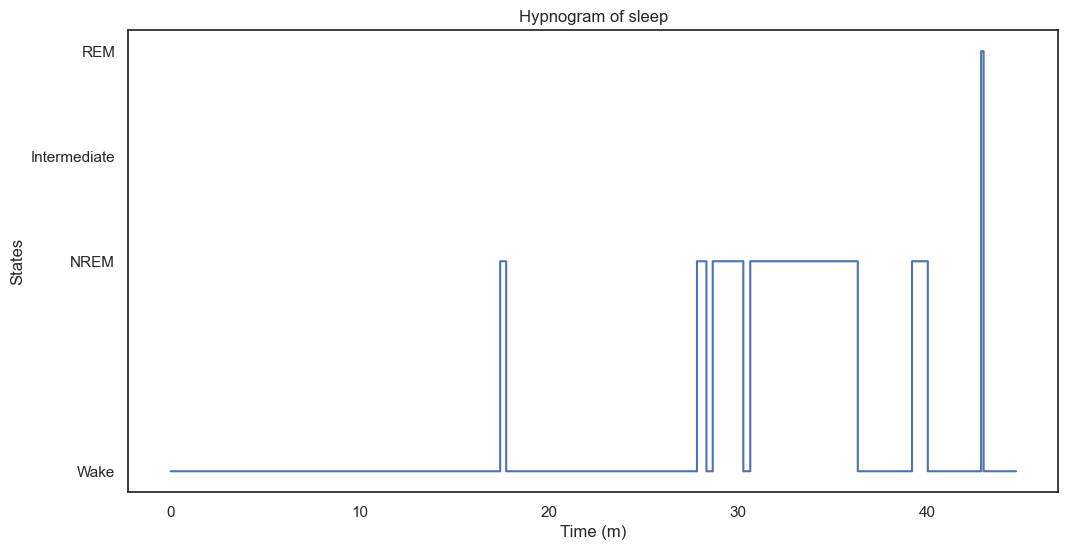

In [4]:
lfpHPC, hypno, fs = get_data(path_to_hpc, path_to_states)
lfpPFC, hypno_pfc, fs = get_data2(path_to_pfc, path_to_states)
plot_hypnogram(hypno)

In [5]:
np.unique(hypno)

array([1, 3, 5], dtype=uint8)

In [6]:
def extract_pt_intervals(lfpHPC, hypno, fs=2500):
    targetFs = 2500
    n_down = fs / targetFs
    start, end = get_start_end(hypno=hypno, sleep_state_id=5)
    rem_interval = nap.IntervalSet(start=start, end=end)
    fs = int(n_down * targetFs)
    t = np.arange(0, len(lfpHPC) / fs, 1 / fs)
    lfp = nap.TsdFrame(t=t, d=lfpHPC, columns=['HPC'])

    # Detect phasic intervals
    lfpHPC_down = preprocess(lfpHPC, n_down)
    phREM = detect_phasic(lfpHPC_down, hypno, targetFs)

    # Create phasic REM IntervalSet
    start, end = [], []
    for rem_idx in phREM:
        for s, e in phREM[rem_idx]:
            start.append(s / targetFs)
            end.append(e / targetFs)
    # Apply a 900 ms duration threshold to phasic intervals
    phasic_interval = nap.IntervalSet(start, end)
    min_duration1 = 0.9  # 900 ms in seconds
    durations1 = phasic_interval['end'] - phasic_interval['start']
    valid_intervals1 = durations1 >= min_duration1
    phasic_interval = nap.IntervalSet(phasic_interval['start'][valid_intervals1], phasic_interval['end'][valid_intervals1])

    # Calculate tonic intervals
    tonic_interval = rem_interval.set_diff(phasic_interval)
    print(f'Number of detected Tonic intervals:{len(tonic_interval)}')
    # Apply a 100 ms duration threshold to tonic intervals
    min_duration = 0.1  # 100 ms in seconds
    durations = tonic_interval['end'] - tonic_interval['start']
    valid_intervals = durations >= min_duration
    tonic_interval = nap.IntervalSet(tonic_interval['start'][valid_intervals], tonic_interval['end'][valid_intervals])
    print(f'Number of detected Tonic intervals after threshold:{len(tonic_interval)}')
    return phasic_interval, tonic_interval, lfp

In [7]:
t = np.arange(0, len(lfpHPC) / fs, 1 / fs)
phasic_interval, tonic_interval, lfp = extract_pt_intervals(lfpHPC, hypno)

len(phasic_interval)

Number of detected Tonic intervals:1
Number of detected Tonic intervals after threshold:1


0

In [8]:
print([phasic_interval])

[index    start    end
-------  -------  -----
shape: (0, 2), time unit: sec.]


In [9]:
print([tonic_interval])

[  index    start    end
      0     2571   2578
shape: (1, 2), time unit: sec.]


In [10]:
interval7 = np.arange(1879.0, 1895.49, 4)
interval8 = np.arange(1897.76, 1942.0, 4)
print(interval7)
print(interval8)

[1879. 1883. 1887. 1891. 1895.]
[1897.76 1901.76 1905.76 1909.76 1913.76 1917.76 1921.76 1925.76 1929.76
 1933.76 1937.76 1941.76]


In [19]:
tonic_time = np.array([
    [2571.0, 2575.0],
    [2575.0, 2578.0]
])

print(tonic_time.size)

4


In [20]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [21]:
for i in range(len(tonic_time)):
    tonic_interval_low = find_nearest(t, tonic_time[i,0])
    tonic_index_low = np.where(t == tonic_interval_low)[0]
    
    tonic_interval_high = find_nearest(t, tonic_time[i,1])
    tonic_index_high = np.where(t == tonic_interval_high)[0]

    signal1 = (lfpHPC[tonic_index_low[0]:tonic_index_high[0]]).T
    print(signal1.size)

10004
7503


In [22]:
highsize = 10004

## Comparison

## Coherence

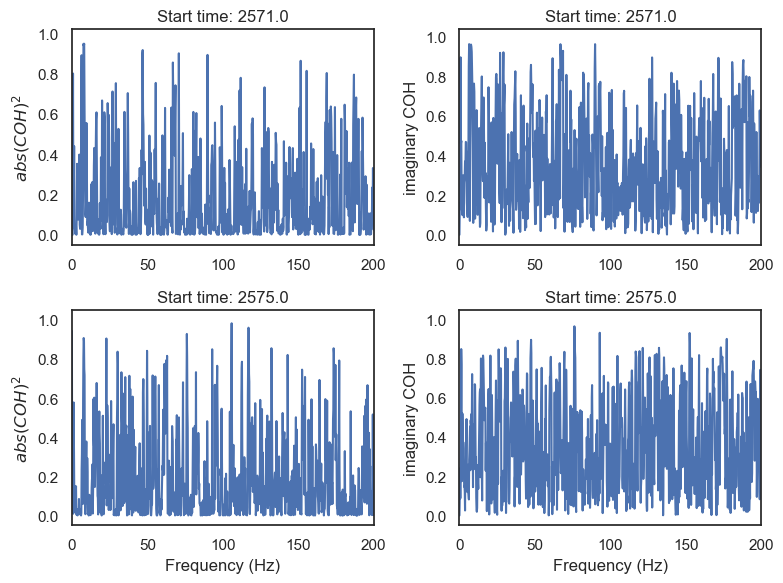

In [27]:
output_folder = "C:/Users/ejsev/Downloads/sleep scoring/outputs/Plots_OS_Basic"
time_halfbandwidth_product = 2 #test value from example
sampling_frequency = 2500
frequency_set = []
coh_set = []
icoh_set = []

fig, axes = plt.subplots(nrows=len(tonic_time), ncols=2, figsize=(8, 6), constrained_layout=True)

for i in range(len(tonic_time)):
    tonic_interval_low = find_nearest(t, tonic_time[i,0])
    tonic_index_low = np.where(t == tonic_interval_low)[0]
    
    tonic_interval_high = find_nearest(t, tonic_time[i,1])
    tonic_index_high = np.where(t == tonic_interval_high)[0]

    signal1 = (lfpHPC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal1_padded = np.pad(signal1, pad_width = (highsize - len(signal1)), mode = 'constant', constant_values = 0)
    signal2 = (lfpPFC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal2_padded = np.pad(signal2, pad_width = (highsize - len(signal2)), mode = 'constant', constant_values = 0)

    signal_tot = np.vstack((signal1_padded.T,signal2_padded.T)).T
    signal_tot.shape

    time = t[tonic_index_low[0]:tonic_index_high[0]]
    time_padded = np.pad(time, pad_width = (highsize - len(time)), mode = 'constant', constant_values = 0)

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    
    frequency_set = np.append(frequency_set,connectivity.frequencies)
    coh_set = np.append(coh_set, np.abs((connectivity.coherence_magnitude()[..., 0, 1].squeeze())**2))
    
    axes[i, 0].plot(
        connectivity.frequencies, np.abs((connectivity.coherence_magnitude()[..., 0, 1].squeeze())**2)
    )
    #axes[0, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[i, 0].set_xlim((0, 200))
    #axes[i, 0].set_title(f"Interval {i+1}, real COH")
    axes[i,0].set_title(f"Start time: {tonic_time[i,0]}")
    #axes[i, 0].set_xlabel('Frequency (Hz)')
    axes[i, 0].set_ylabel('$abs(COH)^2$')

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    icoh_set = np.append(icoh_set, connectivity.imaginary_coherence()[..., 0, 1].squeeze())
    
    axes[i, 1].plot(
        connectivity.frequencies, connectivity.imaginary_coherence()[..., 0, 1].squeeze()
    )
    #axes[1, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[i, 1].set_xlim((0, 200))
    #axes[i, 1].set_title(f"Interval {i+1}, imaginary COH")
    axes[i,1].set_title(f"Start time: {tonic_time[i,0]}")
    #axes[i, 1].set_xlabel('Frequency (Hz)')
    axes[i, 1].set_ylabel('imaginary COH')

axes[len(tonic_time)-1,0].set_xlabel('Frequency (Hz)')
axes[len(tonic_time)-1,1].set_xlabel('Frequency (Hz)')

fig.set_layout_engine(layout='tight')
fig.savefig("tonic_coh_R3T4_HC.png")

mean coh: 0.11303898707589995 +/- 0.0013265609093079033
mean coh: 0.22407885425152296 +/- 0.0027119821787047324
mean coh: 0.2176708551488589 +/- 0.0017955541392654024
mean coh: 0.1850136535443576 +/- 0.001983328357707301
mean icoh: 0.3040955914873166 +/- 0.0016100105952739723
mean icoh: 0.3665997994153318 +/- 0.0023082860436813486
mean icoh: 0.4001274617321786 +/- 0.002143268841988791
mean icoh: 0.35784746553927926 +/- 0.002161544952311869


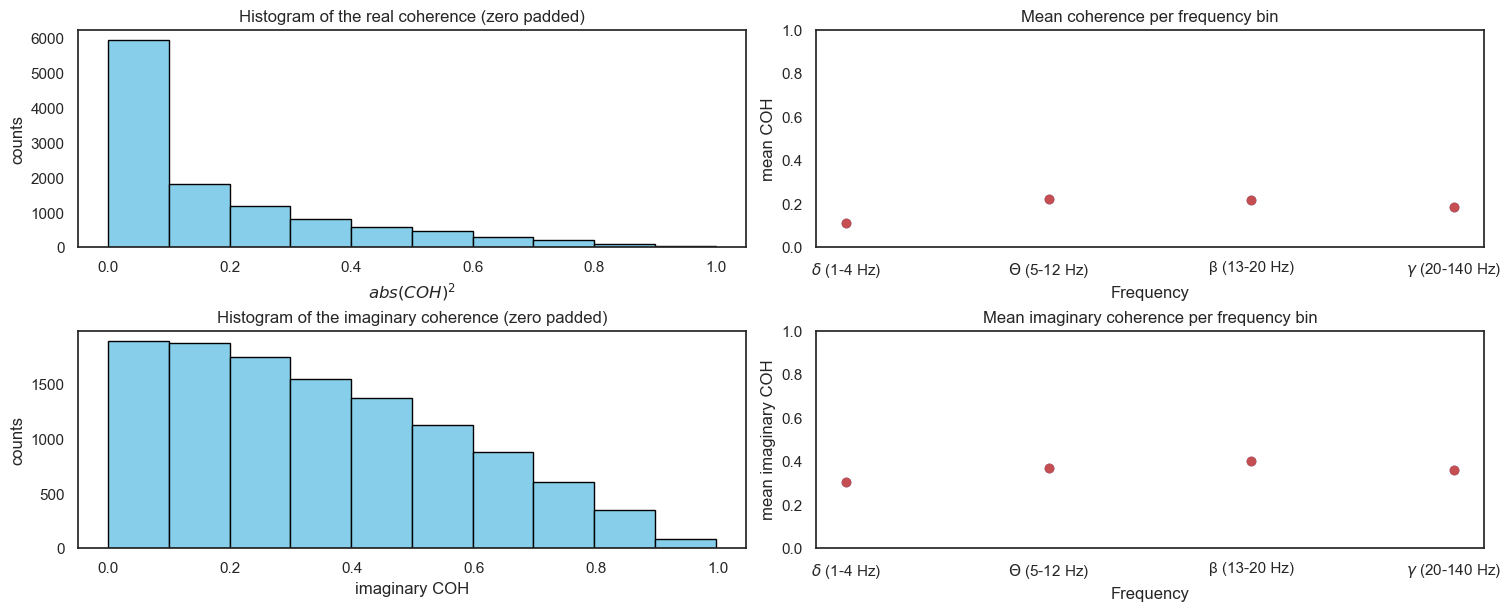

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), constrained_layout=True)

axes[0,0].hist(coh_set, bins=10, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('$abs(COH)^2$')
axes[0,0].set_ylabel('counts')
axes[0,0].set_title('Histogram of the real coherence (zero padded)')

axes[1,0].hist(icoh_set, bins=10, color='skyblue', edgecolor='black')
axes[1,0].set_xlabel('imaginary COH')
axes[1,0].set_ylabel('counts')
axes[1,0].set_title('Histogram of the imaginary coherence (zero padded)')


mean = binned_statistic(frequency_set, coh_set, bins=[1, 5, 13, 20, 140], statistic='mean')
stdev = binned_statistic(frequency_set, coh_set, bins=[1, 5, 13, 20, 140], statistic='std')
n = len(coh_set)

bin_edges = mean.bin_edges
bin_means = mean.statistic
bin_stdev = stdev.statistic
error = bin_stdev/(np.sqrt(n))

frequency_type = ['$\delta$ (1-4 Hz)', '$\Theta$ (5-12 Hz)', 'β (13-20 Hz)', '$\gamma$ (20-140 Hz)']
freq_middle = [3, 8, 16, 80]

axes[0,1].scatter(frequency_type, bin_means)
axes[0,1].errorbar(frequency_type, bin_means, yerr=error, fmt="o", color="r")
axes[0,1].set_ylim(0,1)
#axes[2].set_xlim(0,140)
axes[0,1].set_ylabel('mean COH')
axes[0,1].set_xlabel('Frequency')
axes[0,1].set_title('Mean coherence per frequency bin')

mean2 = binned_statistic(frequency_set, icoh_set, bins=[1, 5, 13, 20, 140], statistic='mean')
stdev2 = binned_statistic(frequency_set, icoh_set, bins=[1, 5, 13, 20, 140], statistic='std')
n2 = len(icoh_set)

bin_edges2 = mean2.bin_edges
bin_means2 = mean2.statistic
bin_stdev2 = stdev2.statistic
error2 = bin_stdev2/(np.sqrt(n2))

axes[1,1].scatter(frequency_type, bin_means2)
axes[1,1].errorbar(frequency_type, bin_means2, yerr=error2, fmt="o", color="r")
axes[1,1].set_ylim(0,1)
#axes[2].set_xlim(0,140)
axes[1,1].set_ylabel('mean imaginary COH')
axes[1,1].set_xlabel('Frequency')
axes[1,1].set_title('Mean imaginary coherence per frequency bin')

#revbinnedstars, edges, _ = binned_statistic(rev_count, stars, 'mean', bins=10)
#revbin = edges[:-1]

for i in range(len(bin_means)):
    print('mean coh:', bin_means[i], '+/-', error[i])

for i in range(len(bin_means)):
    print('mean icoh:', bin_means2[i], '+/-', error2[i])

mean_coh_tonic = bin_means
mean_icoh_tonic = bin_means2
SEM_coh_tonic = error
SEM_icoh_tonic = error2

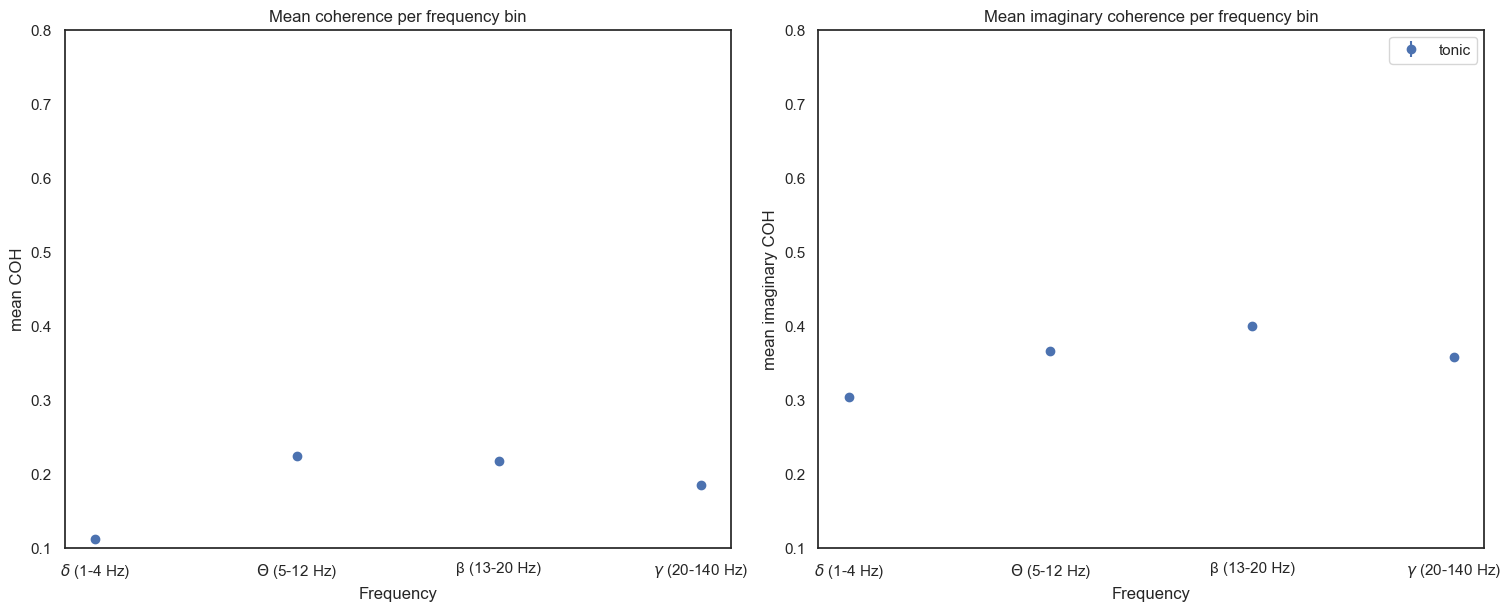

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), constrained_layout=True)
axes[0].errorbar(frequency_type, mean_coh_tonic, yerr=SEM_coh_tonic, fmt="o", label='tonic')
axes[0].set_ylim(0.1,0.8)
#axes[2].set_xlim(0,140)
axes[0].set_ylabel('mean COH')
axes[0].set_xlabel('Frequency')
axes[0].set_title('Mean coherence per frequency bin')

axes[1].errorbar(frequency_type, mean_icoh_tonic, yerr=SEM_icoh_tonic, fmt="o", label='tonic')
axes[1].set_ylim(0.1,0.8)
#axes[2].set_xlim(0,140)
axes[1].set_ylabel('mean imaginary COH')
axes[1].set_xlabel('Frequency')
axes[1].set_title('Mean imaginary coherence per frequency bin')
plt.legend()

## Phase lag index

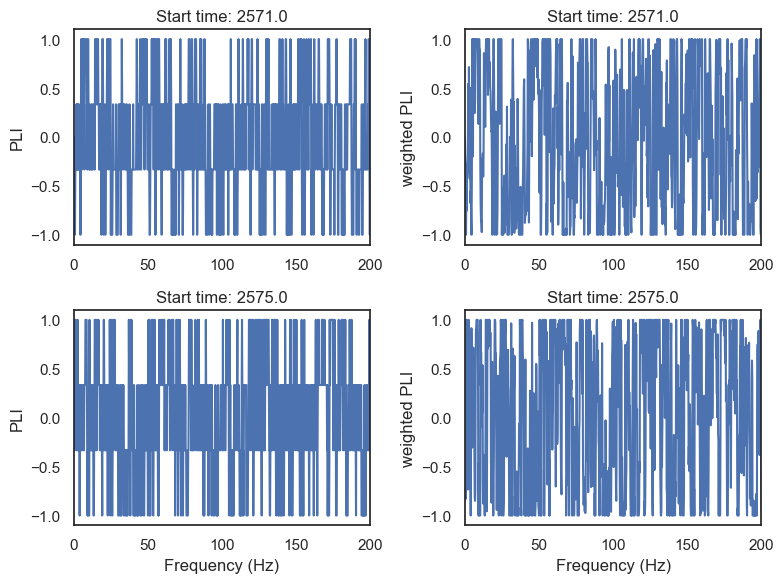

In [32]:
output_folder = "C:/Users/ejsev/Downloads/sleep scoring/outputs/Plots_OS_Basic"
time_halfbandwidth_product = 2 #test value from example
sampling_frequency = 2500
frequency_set = []
pli_set = []
wpli_set = []

fig, axes = plt.subplots(nrows=len(tonic_time), ncols=2, figsize=(8,6), constrained_layout=True)

for i in range(len(tonic_time)):
    tonic_interval_low = find_nearest(t, tonic_time[i,0])
    tonic_index_low = np.where(t == tonic_interval_low)[0]
    
    tonic_interval_high = find_nearest(t, tonic_time[i,1])
    tonic_index_high = np.where(t == tonic_interval_high)[0]

    signal1 = (lfpHPC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal1_padded = np.pad(signal1, pad_width = (highsize - len(signal1)), mode = 'constant', constant_values = 0)
    signal2 = (lfpPFC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal2_padded = np.pad(signal2, pad_width = (highsize - len(signal2)), mode = 'constant', constant_values = 0)

    signal_tot = np.vstack((signal1_padded.T,signal2_padded.T)).T
    signal_tot.shape

    time = t[tonic_index_low[0]:tonic_index_high[0]]
    time_padded = np.pad(time, pad_width = (highsize - len(time)), mode = 'constant', constant_values = 0)

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    
    frequency_set = np.append(frequency_set,connectivity.frequencies)
    pli_set = np.append(pli_set, connectivity.phase_lag_index()[..., 0, 1].squeeze())
    
    axes[i, 0].plot(
        connectivity.frequencies, connectivity.phase_lag_index()[..., 0, 1].squeeze()
    )
    #axes[0, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[i, 0].set_xlim((0, 200))
    #axes[i, 0].set_title(f"Interval {i+1}, real COH")
    axes[i, 0].set_title(f"Start time: {tonic_time[i,0]}")
    #axes[i, 0].set_xlabel('Frequency (Hz)')
    axes[i, 0].set_ylabel('PLI')

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    wpli_set = np.append(wpli_set, connectivity.weighted_phase_lag_index()[..., 0, 1].squeeze())
    axes[i, 1].plot(
        connectivity.frequencies, connectivity.weighted_phase_lag_index()[..., 0, 1].squeeze()
    )
    #axes[1, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[i, 1].set_xlim((0, 200))
    #axes[i, 1].set_title(f"Interval {i+1}, imaginary COH")
    axes[i, 1].set_title(f"Start time: {tonic_time[i,0]}")
    #axes[i, 1].set_xlabel('Frequency (Hz)')
    axes[i, 1].set_ylabel('weighted PLI')

axes[len(tonic_time)-1,0].set_xlabel('Frequency (Hz)')
axes[len(tonic_time)-1,1].set_xlabel('Frequency (Hz)')

fig.set_layout_engine(layout='tight')
fig.savefig("tonic_pli_R3T4_HC.png")

mean pli: -0.018518518518518528 +/- 0.004520301947448271
mean pli: 0.15068493150684928 +/- 0.005381189308524441
mean pli: 0.24999999999999997 +/- 0.005103919729721686
mean pli: -0.02210112019376325 +/- 0.005566947587524329
mean wpli: -0.042197930611027896 +/- 0.006010239179920343
mean wpli: 0.16895154176513424 +/- 0.0067017479127144996
mean wpli: 0.30014023363916253 +/- 0.006440038151886497
mean wpli: -0.02309409663647213 +/- 0.0067973142707924965


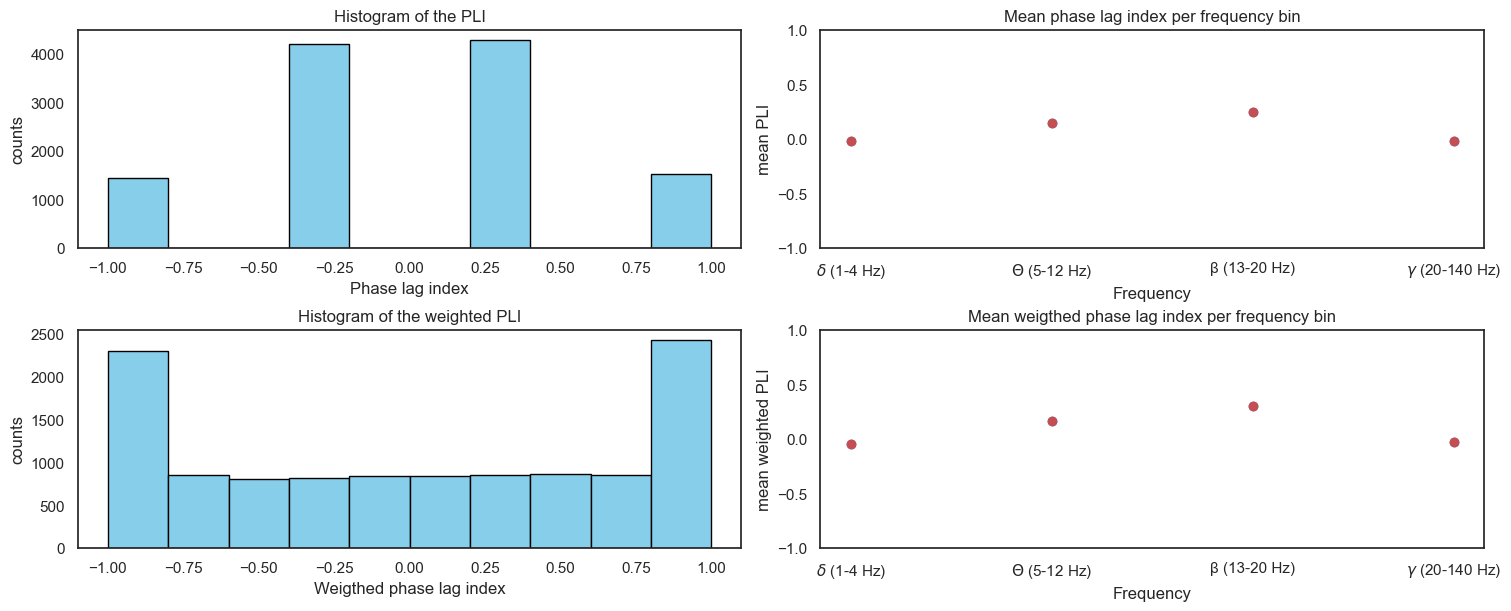

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), constrained_layout=True)

axes[0,0].hist(pli_set, bins=10, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('Phase lag index')
axes[0,0].set_ylabel('counts')
axes[0,0].set_title('Histogram of the PLI')

axes[1,0].hist(wpli_set, bins=10, color='skyblue', edgecolor='black')
axes[1,0].set_xlabel('Weigthed phase lag index')
axes[1,0].set_ylabel('counts')
axes[1,0].set_title('Histogram of the weighted PLI')

mean = binned_statistic(frequency_set, (pli_set), bins=[1, 5, 13, 20, 140], statistic='mean')
stdev = binned_statistic(frequency_set, (pli_set), bins=[1, 5, 13, 20, 140], statistic='std')
n = len(pli_set)

bin_edges = mean.bin_edges
bin_means = mean.statistic
bin_stdev = stdev.statistic
error = bin_stdev/(np.sqrt(n))

freq_middle = [3, 8, 16, 80]

axes[0,1].scatter(frequency_type, bin_means)
axes[0,1].errorbar(frequency_type, bin_means, yerr=error, fmt="o", color="r")
axes[0,1].set_ylim(-1,1)
#axes[2].set_xlim(0,140)
axes[0,1].set_ylabel('mean PLI')
axes[0,1].set_xlabel('Frequency')
axes[0,1].set_title('Mean phase lag index per frequency bin')

mean2 = binned_statistic(frequency_set, (wpli_set), bins=[1, 5, 13, 20, 140], statistic='mean')
stdev2 = binned_statistic(frequency_set, (wpli_set), bins=[1, 5, 13, 20, 140], statistic='std')

bin_edges2 = mean2.bin_edges
bin_means2 = mean2.statistic
bin_stdev2 = stdev2.statistic
error2 = bin_stdev2/(np.sqrt(n))

axes[1,1].scatter(frequency_type, bin_means2)
axes[1,1].errorbar(frequency_type, bin_means2, yerr=error2, fmt="o", color="r")
axes[1,1].set_ylim(-1,1)
#axes[2].set_xlim(0,140)
axes[1,1].set_ylabel('mean weighted PLI')
axes[1,1].set_xlabel('Frequency')
axes[1,1].set_title('Mean weigthed phase lag index per frequency bin')

for i in range(len(bin_means)):
    print('mean pli:', bin_means[i], '+/-', error[i])

for i in range(len(bin_means)):
    print('mean wpli:', bin_means2[i], '+/-', error2[i])
#revbinnedstars, edges, _ = binned_statistic(rev_count, stars, 'mean', bins=10)
#revbin = edges[:-1]
mean_pli_tonic = bin_means
mean_wpli_tonic = bin_means2
SEM_pli_tonic = error
SEM_wpli_tonic = error2

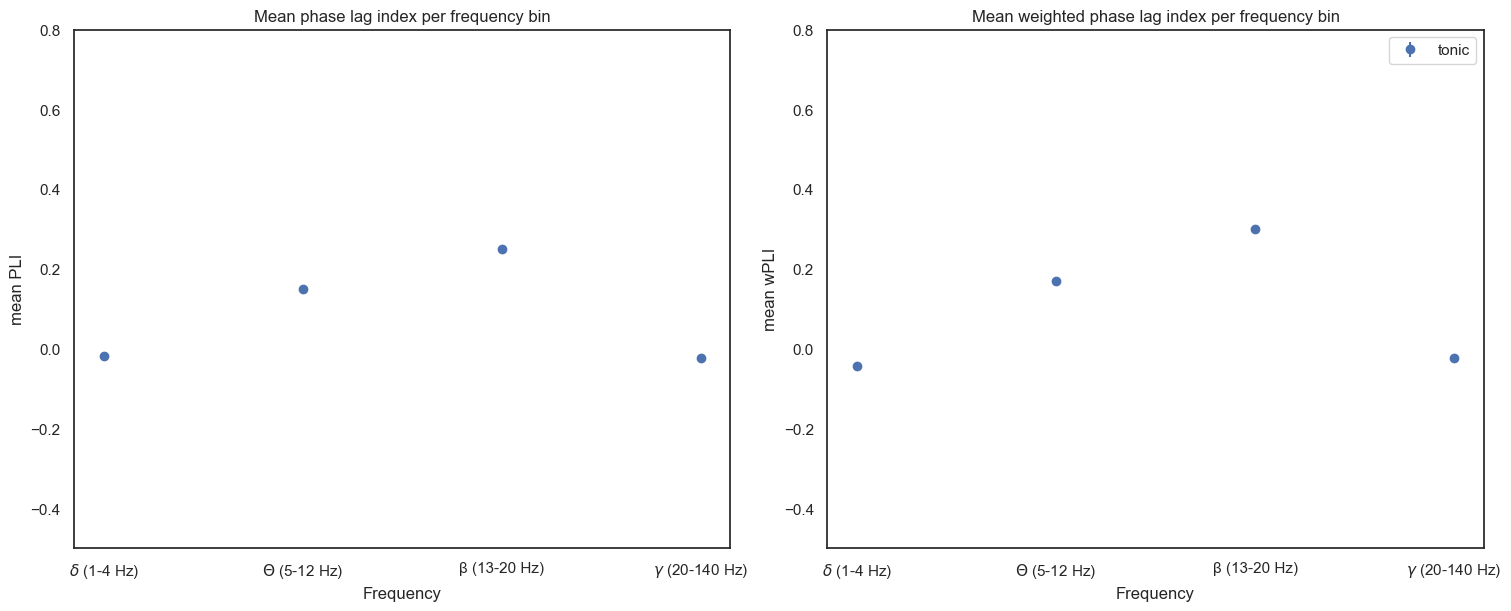

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), constrained_layout=True)
axes[0].errorbar(frequency_type, mean_pli_tonic, yerr=SEM_pli_tonic, fmt="o", label='tonic')
axes[0].set_ylim(-0.5,0.8)
#axes[2].set_xlim(0,140)
axes[0].set_ylabel('mean PLI')
axes[0].set_xlabel('Frequency')
axes[0].set_title('Mean phase lag index per frequency bin')

axes[1].errorbar(frequency_type, mean_wpli_tonic, yerr=SEM_wpli_tonic, fmt="o", label='tonic')
axes[1].set_ylim(-0.5,0.8)
#axes[2].set_xlim(0,140)
axes[1].set_ylabel('mean wPLI')
axes[1].set_xlabel('Frequency')
axes[1].set_title('Mean weighted phase lag index per frequency bin')
plt.legend()

## Debiased squared PLI

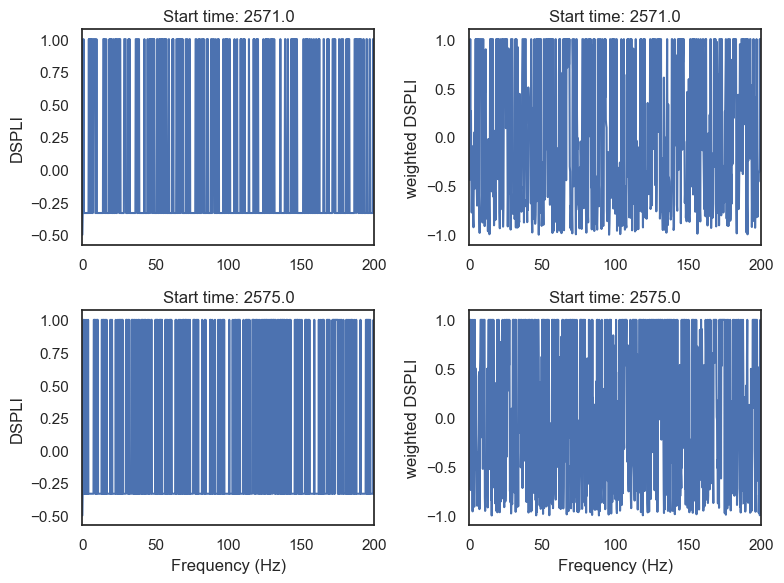

In [35]:
output_folder = "C:/Users/ejsev/Downloads/sleep scoring/outputs/Plots_OS_Basic"
time_halfbandwidth_product = 2 #test value from example
sampling_frequency = 2500
frequency_set = []
frequency_set2 = []
dspli_set = []
wdspli_set = []

fig, axes = plt.subplots(nrows=len(tonic_time), ncols=2, figsize=(8, 6), constrained_layout=True)

for i in range(len(tonic_time)):
    tonic_interval_low = find_nearest(t, tonic_time[i,0])
    tonic_index_low = np.where(t == tonic_interval_low)[0]
    
    tonic_interval_high = find_nearest(t, tonic_time[i,1])
    tonic_index_high = np.where(t == tonic_interval_high)[0]

    signal1 = (lfpHPC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal1_padded = np.pad(signal1, pad_width = (highsize - len(signal1)), mode = 'constant', constant_values = 0)
    signal2 = (lfpPFC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal2_padded = np.pad(signal2, pad_width = (highsize - len(signal2)), mode = 'constant', constant_values = 0)

    signal_tot = np.vstack((signal1_padded.T,signal2_padded.T)).T
    signal_tot.shape

    time = t[tonic_index_low[0]:tonic_index_high[0]]
    time_padded = np.pad(time, pad_width = (highsize - len(time)), mode = 'constant', constant_values = 0)

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    
    frequency_set = np.append(frequency_set,connectivity.frequencies)
    dspli_set = np.append(dspli_set, connectivity.debiased_squared_phase_lag_index()[..., 0, 1].squeeze())
    
    axes[i, 0].plot(
        connectivity.frequencies, connectivity.debiased_squared_phase_lag_index()[..., 0, 1].squeeze(),
    )
    #axes[0, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[i, 0].set_xlim((0, 200))
    #axes[i, 0].set_title(f"Interval {i+1}, real COH")
    axes[i, 0].set_title(f"Start time: {tonic_time[i,0]}")
    #axes[i, 0].set_xlabel('Frequency (Hz)')
    axes[i, 0].set_ylabel('DSPLI')

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    wdspli_set = np.append(wdspli_set, connectivity.debiased_squared_weighted_phase_lag_index()[..., 0, 1].squeeze())
    frequency_set2 = np.append(frequency_set2,connectivity.frequencies)
    axes[i, 1].plot(
        connectivity.frequencies, connectivity.debiased_squared_weighted_phase_lag_index()[..., 0, 1].squeeze(),
    )
    #axes[1, i].set_xlim((0, multitaper.nyquist_frequency))
    axes[i, 1].set_xlim((0, 200))
    #axes[i, 1].set_title(f"Interval {i+1}, imaginary COH")
    axes[i, 1].set_title(f"Start time: {tonic_time[i,0]}")
    #axes[i, 1].set_xlabel('Frequency (Hz)')
    axes[i, 1].set_ylabel('weighted DSPLI')

axes[len(tonic_time)-1,0].set_xlabel('Frequency (Hz)')
axes[len(tonic_time)-1,1].set_xlabel('Frequency (Hz)')

fig.set_layout_engine(layout='tight')
fig.savefig("tonic_dspli_R3T4_HC.png")

mean dspli: -0.14814814814814814 +/- 0.00430678249039781
mean dspli: 0.03196347031963474 +/- 0.005554176325061873
mean dspli: 0.041666666666666685 +/- 0.005599184584394367
mean dspli: 0.03360581289736607 +/- 0.005561923758414961
mean wdspli: -0.11242354151551257 +/- 0.005753775935656929
mean wdspli: 0.03893045577476894 +/- 0.006940786884798998
mean wdspli: 0.03011233422826573 +/- 0.007150482916617625
mean wdspli: 0.026616310269460507 +/- 0.007013729632039044


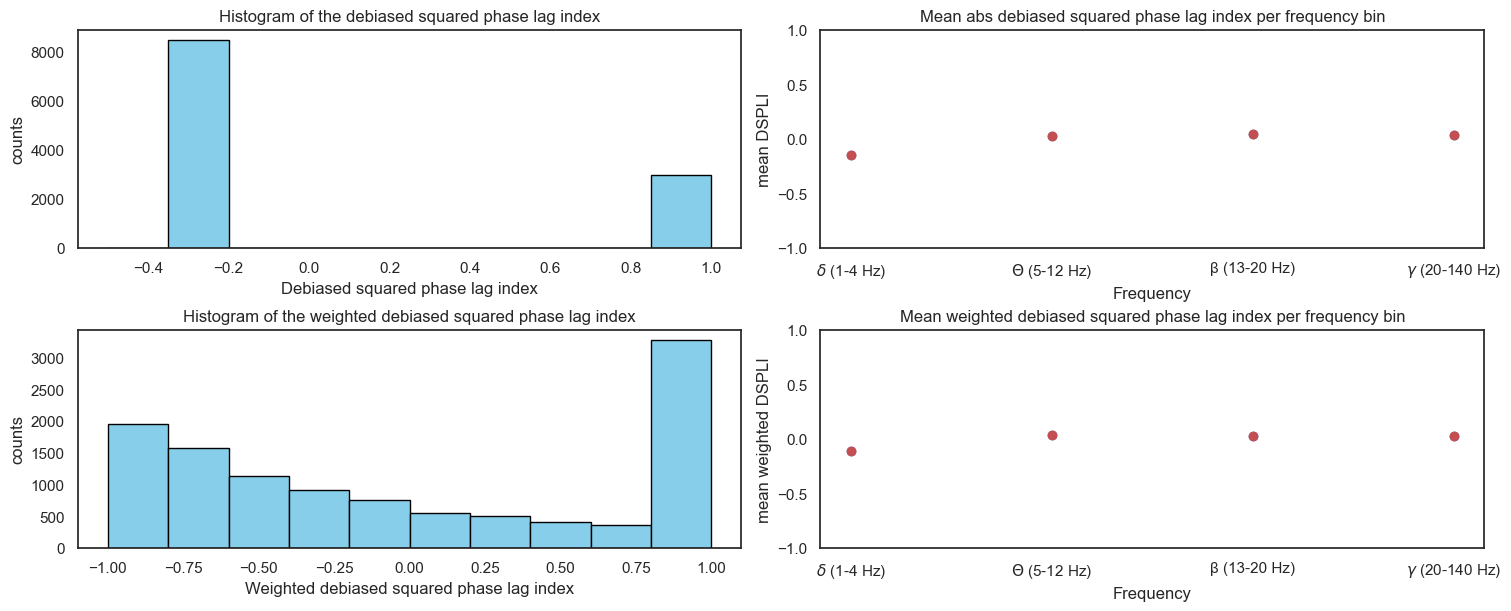

In [36]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), constrained_layout=True)

axes[0,0].hist(dspli_set, bins=10, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('Debiased squared phase lag index')
axes[0,0].set_ylabel('counts')
axes[0,0].set_title('Histogram of the debiased squared phase lag index')

axes[1,0].hist(wdspli_set, bins=10, color='skyblue', edgecolor='black')
axes[1,0].set_xlabel('Weighted debiased squared phase lag index')
axes[1,0].set_ylabel('counts')
axes[1,0].set_title('Histogram of the weighted debiased squared phase lag index')

mean = binned_statistic(frequency_set, dspli_set, bins=[1, 5, 13, 20, 140], statistic='mean')
stdev = binned_statistic(frequency_set, dspli_set, bins=[1, 5, 13, 20, 140], statistic='std')
n = len(dspli_set)

bin_edges = mean.bin_edges
bin_means = mean.statistic
bin_stdev = stdev.statistic
error = bin_stdev/(np.sqrt(n))

freq_middle = [3, 8, 16, 80]

axes[0,1].scatter(frequency_type, bin_means)
axes[0,1].errorbar(frequency_type, bin_means, yerr=error, fmt="o", color="r")
axes[0,1].set_ylim(-1,1)
#axes[2].set_xlim(0,140)
axes[0,1].set_ylabel('mean DSPLI')
axes[0,1].set_xlabel('Frequency')
axes[0,1].set_title('Mean abs debiased squared phase lag index per frequency bin')

mean2 = binned_statistic(frequency_set2, wdspli_set, bins=[1, 5, 13, 20, 140], statistic='mean')
stdev2 = binned_statistic(frequency_set2, wdspli_set, bins=[1, 5, 13, 20, 140], statistic='std')

bin_edges2 = mean2.bin_edges
bin_means2 = mean2.statistic
bin_stdev2 = stdev2.statistic
error2 = bin_stdev2/(np.sqrt(n))

axes[1,1].scatter(frequency_type, bin_means2)
axes[1,1].errorbar(frequency_type, bin_means2, yerr=error2, fmt="o", color="r")
axes[1,1].set_ylim(-1,1)
#axes[2].set_xlim(0,140)
axes[1,1].set_ylabel('mean weighted DSPLI')
axes[1,1].set_xlabel('Frequency')
axes[1,1].set_title('Mean weighted debiased squared phase lag index per frequency bin')

for i in range(len(bin_means)):
    print('mean dspli:', bin_means[i], '+/-', error[i])

for i in range(len(bin_means)):
    print('mean wdspli:', bin_means2[i], '+/-', error2[i])
#revbinnedstars, edges, _ = binned_statistic(rev_count, stars, 'mean', bins=10)
#revbin = edges[:-1]
mean_dspli_tonic = bin_means
mean_wdspli_tonic = bin_means2
SEM_dspli_tonic = error
SEM_wdspli_tonic = error2

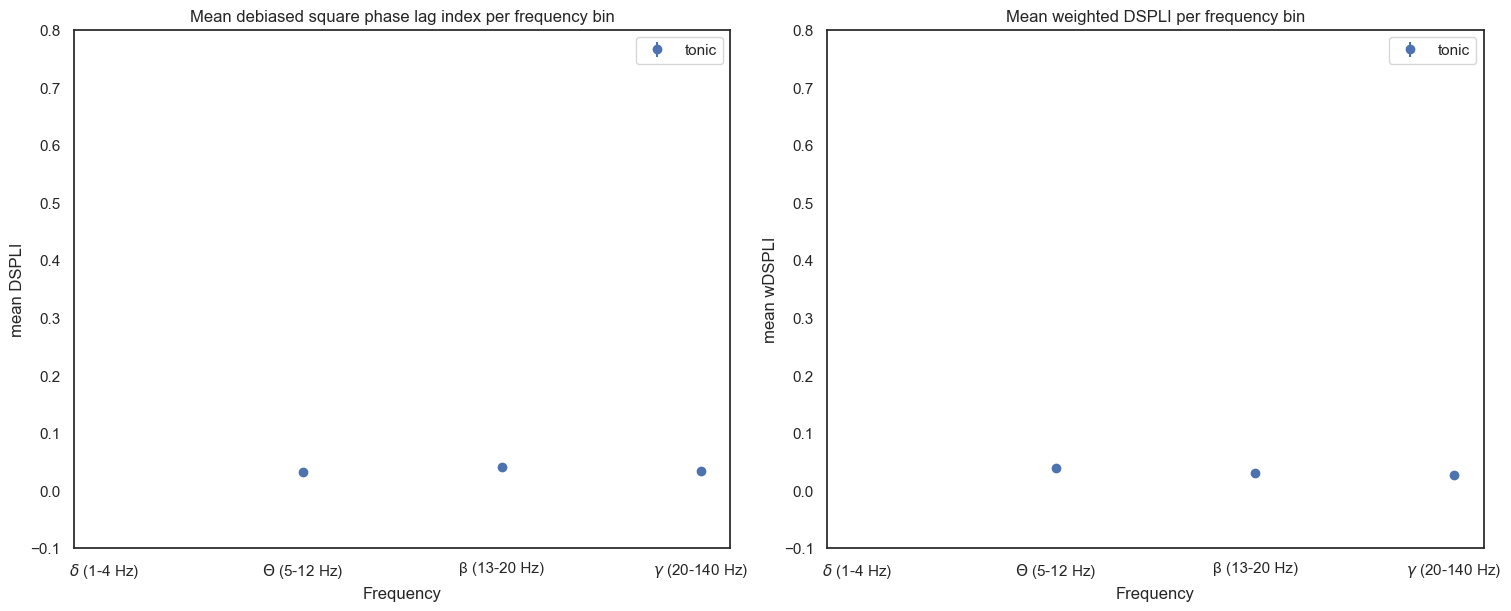

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), constrained_layout=True)
axes[0].errorbar(frequency_type, mean_dspli_tonic, yerr=SEM_dspli_tonic, fmt="o", label='tonic')
axes[0].set_ylim(-0.1,0.8)
#axes[2].set_xlim(0,140)
axes[0].set_ylabel('mean DSPLI')
axes[0].set_xlabel('Frequency')
axes[0].set_title('Mean debiased square phase lag index per frequency bin')
axes[0].legend()

axes[1].errorbar(frequency_type, mean_wdspli_tonic, yerr=SEM_wdspli_tonic, fmt="o", label='tonic')
axes[1].set_ylim(-0.1,0.8)
#axes[2].set_xlim(0,140)
axes[1].set_ylabel('mean wDSPLI')
axes[1].set_xlabel('Frequency')
axes[1].set_title('Mean weighted DSPLI per frequency bin')
plt.legend()

## Pairwise phase consistency

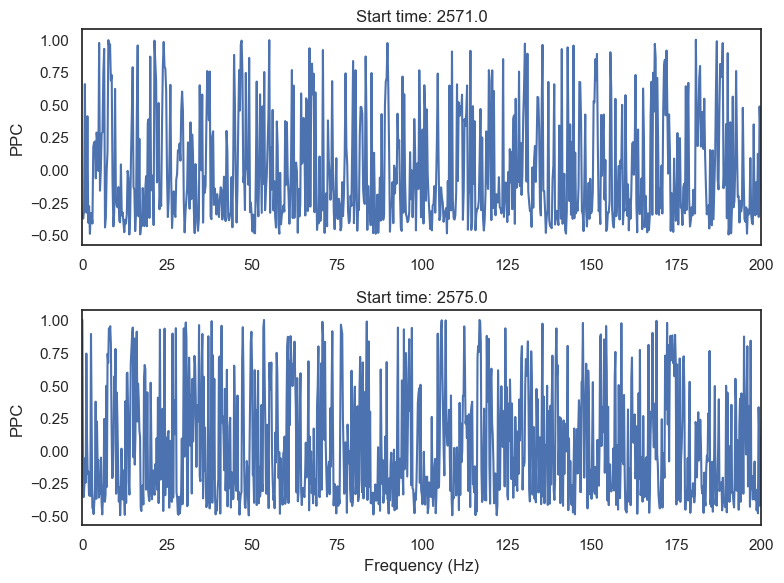

In [38]:
output_folder = "C:/Users/ejsev/Downloads/sleep scoring/outputs/Plots_OS_Basic"
time_halfbandwidth_product = 2 #test value from example
sampling_frequency = 2500
frequency_set = []
ppc_set = []

fig, axes = plt.subplots(nrows=len(tonic_time), ncols=1, figsize=(8, 6), constrained_layout=True)

for i in range(len(tonic_time)):
    tonic_interval_low = find_nearest(t, tonic_time[i,0])
    tonic_index_low = np.where(t == tonic_interval_low)[0]
    
    tonic_interval_high = find_nearest(t, tonic_time[i,1])
    tonic_index_high = np.where(t == tonic_interval_high)[0]

    signal1 = (lfpHPC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal1_padded = np.pad(signal1, pad_width = (highsize - len(signal1)), mode = 'constant', constant_values = 0)
    signal2 = (lfpPFC[tonic_index_low[0]:tonic_index_high[0]]).T
    signal2_padded = np.pad(signal2, pad_width = (highsize - len(signal2)), mode = 'constant', constant_values = 0)

    signal_tot = np.vstack((signal1_padded.T,signal2_padded.T)).T
    signal_tot.shape

    time = t[tonic_index_low[0]:tonic_index_high[0]]
    time_padded = np.pad(time, pad_width = (highsize - len(time)), mode = 'constant', constant_values = 0)

    multitaper = Multitaper(
        signal_tot,
        sampling_frequency=sampling_frequency,
        time_halfbandwidth_product=time_halfbandwidth_product,
        start_time=time_padded[0],
    )
    connectivity = Connectivity.from_multitaper(multitaper)
    
    frequency_set = np.append(frequency_set,connectivity.frequencies)
    ppc_set = np.append(ppc_set, connectivity.pairwise_phase_consistency()[..., 0, 1].squeeze())
    
    axes[i].plot(
        connectivity.frequencies, connectivity.pairwise_phase_consistency()[..., 0, 1].squeeze(),
    )
    #axes[i].set_xlim((0, multitaper.nyquist_frequency))
    axes[i].set_xlim((0, 200))
    #axes[i].set_title(f"Interval {i+1}, real COH")
    axes[i].set_title(f"Start time: {tonic_time[i,0]}")
    #axes[i].set_xlabel('Frequency (Hz)')
    axes[i].set_ylabel('PPC')

axes[len(tonic_time)-1].set_xlabel('Frequency (Hz)')

fig.set_layout_engine(layout='tight')
fig.savefig("tonic_ppc_R3T4_HC.png")

mean ppc: -0.05532880835227386 +/- 0.0036335593091909313
mean ppc: 0.03467086793344153 +/- 0.0044337621932157515
mean ppc: 0.06674959485701412 +/- 0.0042482705261986395
mean ppc: 0.024061296815001486 +/- 0.003939254849281409


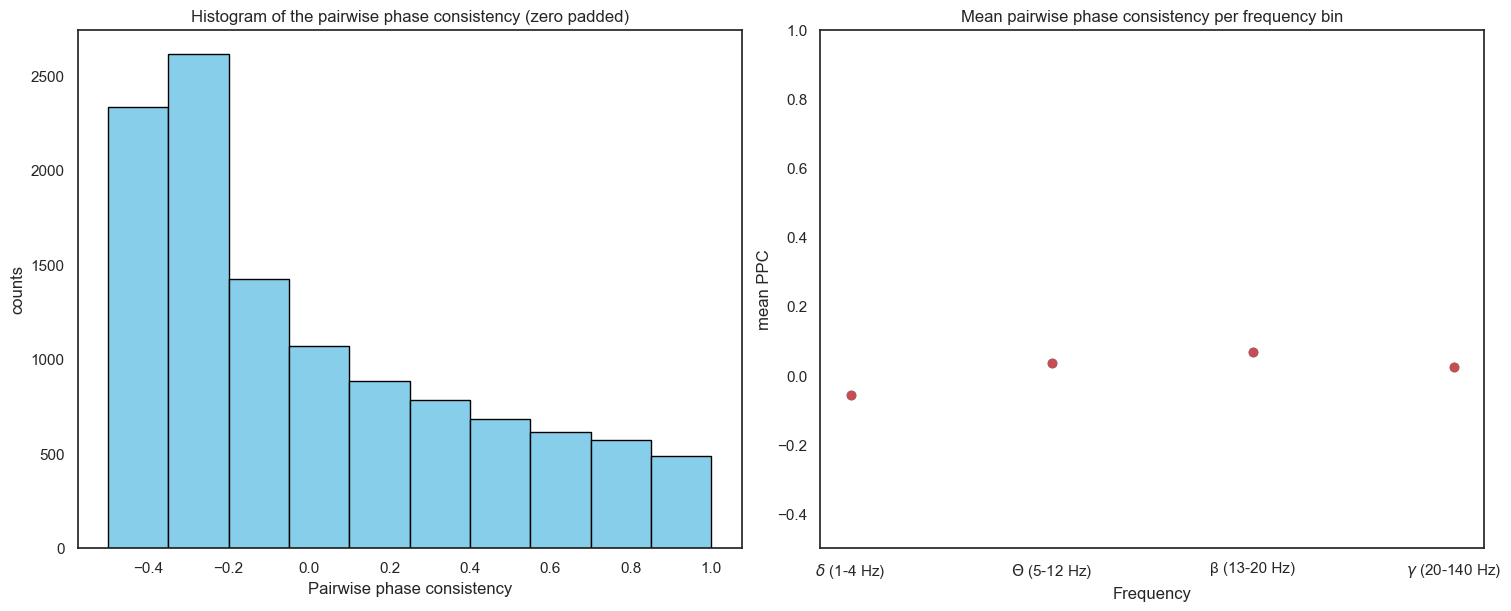

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), constrained_layout=True)

axes[0].hist(ppc_set, bins=10, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Pairwise phase consistency')
axes[0].set_ylabel('counts')
axes[0].set_title('Histogram of the pairwise phase consistency (zero padded)')


mean = binned_statistic(frequency_set, (ppc_set), bins=[1, 5, 13, 20, 140], statistic='mean')
stdev = binned_statistic(frequency_set, (ppc_set), bins=[1, 5, 13, 20, 140], statistic='std')
n = len(ppc_set)

bin_edges = mean.bin_edges
bin_means = mean.statistic
bin_stdev = stdev.statistic
error = bin_stdev/(np.sqrt(n))

freq_middle = [3, 8, 16, 80]

axes[1].scatter(frequency_type, bin_means)
axes[1].errorbar(frequency_type, bin_means, yerr=error, fmt="o", color="r")
axes[1].set_ylim(-0.5,1)
#axes[2].set_xlim(0,140)
axes[1].set_ylabel('mean PPC')
axes[1].set_xlabel('Frequency')
axes[1].set_title('Mean pairwise phase consistency per frequency bin')

for i in range(len(bin_means)):
    print('mean ppc:', bin_means[i], '+/-', error[i])
#revbinnedstars, edges, _ = binned_statistic(rev_count, stars, 'mean', bins=10)
#revbin = edges[:-1]
mean_ppc_tonic = bin_means
SEM_ppc_tonic = error

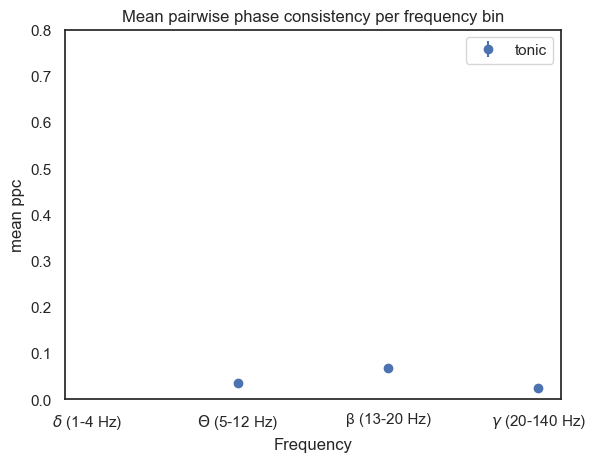

In [40]:
plt.errorbar(frequency_type, mean_ppc_tonic, yerr=SEM_ppc_tonic, fmt="o", label='tonic')
plt.ylim(0,0.8)
plt.ylabel('mean ppc')
plt.xlabel('Frequency')
plt.title('Mean pairwise phase consistency per frequency bin')
plt.legend()

## Table

In [41]:
mean_coh = np.hstack((mean_coh_tonic))
mean_icoh = np.hstack((mean_icoh_tonic))
mean_pli = np.hstack((mean_pli_tonic))
mean_wpli = np.hstack((mean_wpli_tonic))
mean_dspli = np.hstack((mean_dspli_tonic))
mean_wdspli = np.hstack((mean_wdspli_tonic))
mean_ppc = np.hstack((mean_ppc_tonic))

SEM_coh = np.hstack((SEM_coh_tonic))
SEM_icoh = np.hstack((SEM_icoh_tonic))
SEM_pli = np.hstack((SEM_pli_tonic))
SEM_wpli = np.hstack((SEM_wpli_tonic))
sem_dspli = np.hstack((SEM_dspli_tonic))
sem_wdspli = np.hstack((SEM_wdspli_tonic))
SEM_ppc = np.hstack((SEM_ppc_tonic))

In [44]:
print(mean_coh)

[0.11303899 0.22407885 0.21767086 0.18501365]


In [47]:
rows = []
for i in range(4):
    rows.append({
                    'COH': mean_coh[i],
                    'SE COH': SEM_coh[i],
                    'iCOH': mean_icoh[i],
                    'SE iCOH': SEM_icoh[i],
                    'PLI': mean_pli[i],
                    'SE PLI': SEM_pli[i],
                    'wPLI': mean_wpli[i],
                    'SE wPLI': SEM_wpli[i],
                    'DSPLI': mean_dspli[i],
                    'SE DSPLI': sem_dspli[i],
                    'wDSPLI': mean_wdspli[i],
                    'SE wDSPLI': sem_wdspli[i],
                    'PPC': mean_ppc[i],
                    'SE PPC': SEM_ppc[i]
                })
df = pd.DataFrame(rows, index = ["tonic delta", "tonic theta", "tonic theta-gamma", "tonic gamma"])
df.to_csv('C:/Users/ejsev/Downloads/sleep scoring/table_connectivity_R3T4_HC.csv', index=True)
df

,COH,SE COH,iCOH,SE iCOH,PLI,SE PLI,wPLI,SE wPLI,DSPLI,SE DSPLI,wDSPLI,SE wDSPLI,PPC,SE PPC
tonic delta,0.113039,0.001327,0.304096,0.001610,-0.018519,0.004520,-0.042198,0.006010,-0.148148,0.004307,-0.112424,0.005754,-0.055329,0.003634
tonic theta,0.224079,0.002712,0.366600,0.002308,0.150685,0.005381,0.168952,0.006702,0.031963,0.005554,0.038930,0.006941,0.034671,0.004434
tonic theta-gamma,0.217671,0.001796,0.400127,0.002143,0.250000,0.005104,0.300140,0.006440,0.041667,0.005599,0.030112,0.007150,0.066750,0.004248
tonic gamma,0.185014,0.001983,0.357847,0.002162,-0.022101,0.005567,-0.023094,0.006797,0.033606,0.005562,0.026616,0.007014,0.024061,0.003939
